<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/ML%20deployment-%20AWS.SageMaker/Boston_House(AWS_SageMaker_Custom_Batch_Transform).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AWS SAGEMAKER 

Hello, I am [Vedant_Dave](https://vedantdave77.github.io/), a inspirational machine learning practitioner.
## Intro To Topic
Today, I am going to deploy Boston Housing data Project using AWS Sagemaker's High level API called - "Python SDK". 
> This API has facility to train and deploy model in cloud directly from innner Jupyter notebook creation. So, I will use simple Machine learning workflow as usaual. 

> Data loading --> Data Preparation --> Model Training --> HP Tuning --> Deployment in AWS. (Hopefully, try to make Web Application). 

---
---

First of all, I will use SageMaker's batch transform feature, which  is a high-performance and high-throughput method for transforming data and generating inferences. 

- I personally think, It's ideal for scenarios where you're dealing with large batches of data, don't need sub-second latency, or need to both preprocess and transform the training data. 

- My main focus is to deploy model, so on analytic point of view, I tried to use Sagemaker's ML library and find median housing price for specific housing requrements in certain areas. 

 


## Set Environment (lib & SageMaker)

In [1]:
# Setting-up Notebook in relevant environment.

import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_boston
import sklearn.model_selection

In [2]:
# set sagemaker in env.
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# Object to represent current active session of sagemaker - contains some useful info. for future usage.
session = sagemaker.Session()

# object shows IAM role - will help us to assign training job to sagemaker.
role = get_execution_role()

## Download Data 

In [3]:
# download data from sagemeaker internal data collection
boston = load_boston()


## Data preparation and splitting.


In [12]:
# prepare data for python notebook
X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
y_bos_pd = pd.DataFrame(boston.target)

# splitting into train and test
X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X_bos_pd, y_bos_pd, test_size =0.33)

# further splitting of train to train(2/3) and validation(1/3)
y_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.33)

## Uploading data files to S3.

Keep in mind that, 

- When a training job is constructed using SageMaker, a container is executed which performs the training operation.
- This container is given access to data that is stored in S3. This means that we need to upload the data we want to use for training to S3. 
- In addition, when we perform a batch transform job, SageMaker expects the input data to be stored on S3. We can use the SageMaker API to do this and hide some of the details, but first data saved locally and then uploaded to S3 container.




In [13]:
# define & ensure data dictionary...
data_dir = '.../data/boston'
if not os.path.exists(data_dir):
  os.makedirs(data_dir)

In [14]:
# In data_dir, I amd creating csv file format for all data, and in validation and train set target data comes in first columns.

X_test.to_csv(os.path.join(data_dir,'test.csv'),header = False, index = False)
 
pd.concat([y_val,X_val], axis =1).to_csv(os.path.join(data_dir, 'validation.csv'),header=False, index= False)
pd.concat([y_train,X_train],axis =1).to_csv(os.path.join(data_dir,'train.csv'),header=False,index=False)

### Upload to S3 - data storage.
Its good prectice to give prefix to your S3 bucket, so you can easily get idea about specific container for relevant project. 
- Here, I am giving name as "dataset_name-algorithm_name-API_level".

I will use xgboost algorithm, which is one of the modern approach for supervised learning. It boost our algorithm gradient and give high accuracy result with good F1 score Matrix. 

> For more info, visit [XGBoost](https://xgboost.readthedocs.io/en/latest/) official documentation.

In [15]:
prefix = 'boston-xgboost-LL'

test_location = session.upload_data(os.path.join(data_dir,'test.csv'),key_prefix = prefix)
val_location = session.upload_data(os.path.join(data_dir,'validation.csv'), key_prefix = prefix)
train_location = session.upload_data(os.path.join(data_dir,'train.csv'),key_prefix = prefix)

'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.
'upload_data' method will be deprecated in favor of 'S3Uploader' class (https://sagemaker.readthedocs.io/en/stable/s3.html#sagemaker.s3.S3Uploader) in SageMaker Python SDK v2.


## Train and construct the XGBoost Model

### setup the training job

For setup training job I need to know the exact information about my sagemaker, s3 container and other general information regarding instance. 

- I am using this [API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTrainingJob.html) provided by sagemaker for reference to create this training job.


In [16]:
# We will need to know the name of the container that we want to use for training. SageMaker provides  a nice utility method to construct this for us.
container = get_image_uri(session.boto_region_name, 'xgboost')

# specify parameters for tranining job
training_params = {}

# specify training role (IAM) of this session [same as sagemaker role]
training_params['RoleArn'] = role

# specify training algorithm and container for job
training_params['AlgorithmSpecification'] = {
    "TrainingImage": container,
    "TrainingInputMode": "File"
}

# specify output (model artifacts-model change) space [in s3]
training_params['OutputDataConfig'] = {
    "S3OutputPath": "s3://" + session.default_bucket() + "/" + prefix + "/output"
}

# specify computer capability provided to instance and stopping condition in case or error.
training_params['ResourceConfig'] = {
    "InstanceCount": 1,
    "InstanceType": "ml.m4.xlarge",
    "VolumeSizeInGB": 5
}
    
training_params['StoppingCondition'] = {        # conditional stopping in case of Error.
    "MaxRuntimeInSeconds": 86400
}

# XGBoost model hyper parameters.
training_params['HyperParameters'] = {
    "max_depth": "5",
    "eta": "0.2",
    "gamma": "4",
    "min_child_weight": "6",
    "subsample": "0.8",
    "objective": "reg:linear",
    "early_stopping_rounds": "10",
    "num_round": "200"
}

# define the data path (from where and what kind of data sagemaker will retrive)
training_params['InputDataConfig'] = [
    {
        "ChannelName": "train",                                                 # which data 
        "DataSource": {            
            "S3DataSource": {
                "S3DataType": "S3Prefix",                                       # data identification
                "S3Uri": train_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",                                                   # what kind of data 
        "CompressionType": "None"                                               # large data may be compressed
    },
    {
        "ChannelName": "validation",                                            # same as above for validation
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": val_location,
                "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "csv",
        "CompressionType": "None"
    }
]

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
	get_image_uri(region, 'xgboost', '1.0-1').


### Execute the training job 
Give command to execute after knowing above data.



In [19]:
import time
from time import gmtime, strftime

In [20]:
training_job_name = "boston-xgboost-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
training_params['TrainingJobName'] = training_job_name

# And now we ask SageMaker to create (and execute) the training job
training_job = session.sagemaker_client.create_training_job(**training_params)

In [21]:
# Its lengthy job so we need to wait until gettingthe anwer.
session.logs_for_job(training_job_name, wait=True)

2020-06-06 17:30:25 Starting - Starting the training job...
2020-06-06 17:30:27 Starting - Launching requested ML instances......
2020-06-06 17:31:34 Starting - Preparing the instances for training...
2020-06-06 17:32:16 Downloading - Downloading input data...
2020-06-06 17:32:56 Training - Training image download completed. Training in progress..Arguments: train
[2020-06-06:17:32:57:INFO] Running standalone xgboost training.
[2020-06-06:17:32:57:INFO] File size need to be processed in the node: 0.03mb. Available memory size in the node: 8485.06mb
[2020-06-06:17:32:57:INFO] Determined delimiter of CSV input is ','
[17:32:57] S3DistributionType set as FullyReplicated
[17:32:57] 339x13 matrix with 4407 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-06:17:32:57:INFO] Determined delimiter of CSV input is ','
[17:32:57] S3DistributionType set as FullyReplicated
[17:32:57] 112x13 matrix with 1456 entries loaded from /opt/ml/input/data/validation?f

### Build the model
The above job give us lot of information and its hard to understand according to data structure so its better to understand it from sagemaaker ownself. 

- Then we will make model (not a ml model but model for sagemaker information collection.

In [22]:
training_job_info = session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)

model_artifacts = training_job_info['ModelArtifacts']['S3ModelArtifacts']

In [24]:
# give model a unique name by (training job name - mode - so, helpful to distinguish each and every job seperately)
model_name = training_job_name + "-model"

# specify information for sagemaker to understand which container need to use for interference and wher it is situated.
primary_container = {
    "Image": container,
    "ModelDataUrl": model_artifacts
}

# And lastly we construct the SageMaker model
model_info = session.sagemaker_client.create_model(
                                ModelName = model_name,
                                ExecutionRoleArn = role,
                                PrimaryContainer = primary_container)

### Testing the Model.

We already have trained model now and validation also do its best job to make model more generalize and model will not overfit. 

Now, we will use batch transform (sagemaker testing method) and for that we will first define training parameters, sagemake information model and information saving data structure with s3.
> I will take help from this [API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_CreateTransformJob.html) to build it up.

In [30]:
# define job name and timing specification
transform_job_name = 'boston-xgboost-batch-transform-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# define datastructure for batch transfer job 
transform_request = \
{
    "TransformJobName": transform_job_name,
    
    # specify model name.
    "ModelName": model_name,
    
    # specify no. of instance connect with job (for ensurity with job status)
    "MaxConcurrentTransforms": 1,
    
    # specify max split chunk limit so in backgroud job each chunk shold be within this range
    "MaxPayloadInMB": 6,
    
    # specify chunk to give multiple input sample (sometime we only need single)
    "BatchStrategy": "MultiRecord",
    
    # specify output storage (in s3 container)
    "TransformOutput": {
        "S3OutputPath": "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)
    },
    
    # we are using chunk so need to define how and where this file should be appeared.
    "TransformInput": {
        "ContentType": "text/csv",
        "SplitType": "Line",
        "DataSource": {
            "S3DataSource": {
                "S3DataType": "S3Prefix",
                "S3Uri": test_location,
            }
        }
    },
    
    # And lastly we tell SageMaker what sort of compute instance we want to use
    "TransformResources":{                                                           ##### Add transfrom Job (bug fixed)
            "InstanceType" : "ml.m4.xlarge",
            "InstanceCount": 1
    }
}

### Execute batch transefer job.
As above with training, after creating batch transfer job we should define the execution cmmand

In [31]:
transform_response = session.sagemaker_client.create_transform_job(**transform_request)

In [32]:
transform_desc = session.wait_for_transform_job(transform_job_name)

............................................!


### Result visazlization
Now we will analyze the result, but before that I saved this model data to notebook stance from S3, its convenient stragegy for us. But it will incrase data load on instance by adding trained model.

In [33]:
transform_output = "s3://{}/{}/batch-bransform/".format(session.default_bucket(),prefix)

In [34]:
!aws s3 cp --recursive $transform_output $data_dir    # take data locally to use it after.

download: s3://sagemaker-us-west-2-337299574287/boston-xgboost-LL/batch-bransform/test.csv.out to .../data/boston/test.csv.out


Text(0.5, 1.0, 'Median Price vs Predicted Price')

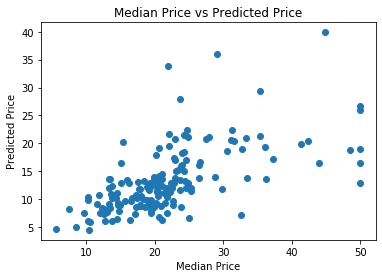

In [36]:
y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
plt.scatter(y_test, y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

### Clean up the disk and directory 
Here, I am also going to run other notebooks on same notebook instance and sometime it raised error, which is hard to resolve. So, its better to clean disk when you do not want to use it more. well do not forget to stop notebook instance. Just stop it. DO NOT TERMINATE. Thank you.

In [0]:
# remove all of the files contained in the data_dir directory
!rm $data_dir/*

# delete the directory itself
!rmdir $data_dir

In [0]:
# "Keep Learning, Enjoy Empowering" @dave117